# Raster Analysis

This is additional supplementary to the original report. I have saved this code here because of the large amount of RAM required to run this. Please try not to run this as, by experience, it would take more than 2 hours to run.

In [1]:
import re, functools
from glob import glob
import rasterio as rs
import rasterstats as rstats
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
countries_geojson = gp.read_file("https://datahub.io/core/geo-ne-admin1/r/admin1.geojson")
countries_geojson.to_file("data/country/world_locations.json", driver='GeoJSON')
countries_geojson

,ISO3166-1-Alpha-3,country,id,name,geometry
0,ABW,Aruba,5150,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,AFG,Afghanistan,1741,Badghis,"POLYGON ((64.30624 35.39722, 64.32468 35.40177..."
2,AFG,Afghanistan,1742,Hirat,"POLYGON ((61.36393 35.59824, 61.36548 35.59850..."
3,AFG,Afghanistan,1743,Bamyan,"POLYGON ((67.74391 35.44342, 67.75476 35.44412..."
4,AFG,Afghanistan,1744,Balkh,"POLYGON ((67.25913 37.18515, 67.28145 37.18866..."
...,...,...,...,...,...
4642,ZWE,Zimbabwe,529,Manicaland,"POLYGON ((33.01165 -17.38399, 32.99745 -17.404..."
4643,ZWE,Zimbabwe,530,Matabeleland South,"POLYGON ((29.43994 -19.87930, 29.45699 -19.874..."
4644,ZWE,Zimbabwe,531,Bulawayo,"POLYGON ((28.49757 -20.06270, 28.50532 -20.062..."
4645,ZWE,Zimbabwe,532,Masvingo,"POLYGON ((31.04181 -19.25226, 31.19870 -19.248..."


In [2]:
countries_geojson = gp.read_file("data/country/world_locations.json")
countries_geojson

,ISO3166-1-Alpha-3,country,id,name,geometry
0,ABW,Aruba,5150,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,AFG,Afghanistan,1741,Badghis,"POLYGON ((64.30624 35.39722, 64.32468 35.40177..."
2,AFG,Afghanistan,1742,Hirat,"POLYGON ((61.36393 35.59824, 61.36548 35.59850..."
3,AFG,Afghanistan,1743,Bamyan,"POLYGON ((67.74391 35.44342, 67.75476 35.44412..."
4,AFG,Afghanistan,1744,Balkh,"POLYGON ((67.25913 37.18515, 67.28145 37.18866..."
...,...,...,...,...,...
4642,ZWE,Zimbabwe,529,Manicaland,"POLYGON ((33.01165 -17.38399, 32.99745 -17.404..."
4643,ZWE,Zimbabwe,530,Matabeleland South,"POLYGON ((29.43994 -19.87930, 29.45699 -19.874..."
4644,ZWE,Zimbabwe,531,Bulawayo,"POLYGON ((28.49757 -20.06270, 28.50532 -20.062..."
4645,ZWE,Zimbabwe,532,Masvingo,"POLYGON ((31.04181 -19.25226, 31.19870 -19.248..."


<AxesSubplot:>

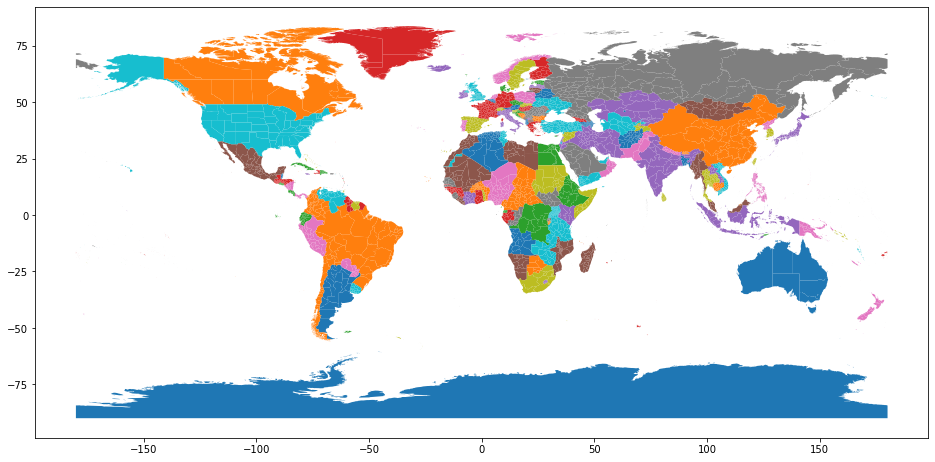

In [4]:
countries_geojson.plot("country", figsize=(16, 8))

In [7]:
def retrieveGeoStats(raster_file, nodata=255):
    year = re.search(r"\d+", raster_file).group()
    print(f"Processing {year}...", end="\t")
    rf = rs.open(raster_file,"r")
    values = pd.DataFrame(rstats.zonal_stats(countries_geojson, rf.read(1), affine=rf.transform, stats=["count", "mean", "min", "max", 'median', 'std', "majority"], geojson_out=True, nodata=nodata))
    del rf
    #return countries_geojson.merge()
    df = pd.concat([values, values.properties.apply(pd.Series)], axis=1).drop(columns=["id", "type", "properties", "bbox", "ISO3166-1-Alpha-3", "geometry"]).rename(columns={"majority": "mode"}).set_index(["country", "name"]).rename(columns=lambda q: (year, q)).T.reset_index().fillna(0)
    df.loc[:, ["Year", "Quantity"]] = df["index"].apply(pd.Series).rename(columns={0:"Year", 1:"Quantity"})
    return df.drop(columns=["index"]).set_index(["Year", "Quantity"])
    #return pd.concat([values, values.properties.apply(pd.Series)], axis=1).drop(columns=["geometry", "properties", "ISO3166-1-Alpha-3"]).rename(columns={"majority":"mode"}).set_index(["country", "bbox"]).drop(columns=["id", "type"]).rename(columns=lambda name: f"{name}LightPollution{year}").rename(columns={f"countLightPollution{year}":f"recordCount{year}"}).reset_index()

nightLight2013 = retrieveGeoStats("data/nightLight/DN_NTL_2013_simVIIRS.tif")
nightLight2013

Processing 2013...	

C:\Users\Prannaya\.conda\envs\analytics\lib\site-packages\IPython\core\interactiveshell.py:3169: PerformanceWarning: indexing past lexsort depth may impact performance.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


ValueError: cannot handle a non-unique multi-index!

In [10]:
nightLight2013.rename(columns=lambda tup: tup[-1]).to_csv("data/nightLight/nightLight2013.csv")
nightLight2013.rename(columns=lambda tup: tup[-1])

min   max       mean  count        std  \
country     name                                                         
Aruba       Aruba               7.0  57.0  28.666667    201  16.178831   
Afghanistan Badghis             0.0  32.0   0.236040  29334   1.336606   
            Hirat               0.0  56.0   0.741159  78071   2.932197   
            Bamyan              0.0   8.0   0.180535  25153   1.039803   
            Balkh               0.0  61.0   2.011429  23275   5.675208   
...                             ...   ...        ...    ...        ...   
Zimbabwe    Manicaland          0.0  46.0   1.915220  42982   3.263857   
            Matabeleland South  0.0  52.0   0.677659  68170   2.175918   
            Bulawayo            0.0  55.0  21.061511    569  15.322821   
            Masvingo            0.0  26.0   0.701861  69850   2.066331   
            Mashonaland West    0.0  49.0   4.252489  70118   3.467990   

                                median  mode  
country     name                              
Aruba       Aruba                 28.0   7.0  
Afghanistan Badghis                0.0   0.0  
            Hirat                  0.0   0.0  
            Bamyan                 0.0   0.0  
            Balkh                  0.0   0.0  
...                                ...   ...  
Zimbabwe    Manicaland             0.0   0.0  
            Matabeleland South     0.0   0.0  
            Bulawayo              14.0   7.0  
            Masvingo               0.0   0.0  
            Mashonaland West       6.0   6.0  

[4647 rows x 7 columns]

In [6]:
nightLight2013.dtypes

(2013, min)       float64
(2013, max)       float64
(2013, mean)      float64
(2013, count)       int64
(2013, std)       float64
(2013, median)    float64
(2013, mode)      float64
dtype: object

In [5]:
nightLight = functools.reduce(pd.DataFrame.join, map(retrieveGeoStats, glob("data/nightLight/Harmonized*.tif")))
nightLight

Processing 1992...	Processing 1993...	Processing 1994...	Processing 1995...	Processing 1996...	Processing 1997...	Processing 1998...	Processing 1999...	Processing 2000...	Processing 2001...	Processing 2002...	Processing 2003...	Processing 2004...	Processing 2005...	Processing 2006...	

MemoryError: Unable to allocate 117. MiB for an array with shape (1, 15336531) and data type int64

In [ ]:
df = nightLight.T.reset_index().fillna(0)
df.loc[:, ["Year", "Quantity"]] = df["index"].apply(pd.Series).rename(columns={0:"Year", 1:"Quantity"})
df = df.drop(columns=["index"]).set_index(["Year", "Quantity"])
df.to_csv("data/nightLight/nightLight.csv")
del df
nightLightCSV = pd.read_csv("data/nightLight/nightLight.csv")
nightLightCSV

In [ ]:
data = nightLightCSV.set_index(["Quantity", "Year"]).loc["mean"].T.rename(columns="nightLight{}".format).reset_index()
data

In [ ]:
corr = data.drop(columns="index").corr()
corr

In [ ]:
sns.heatmap(corr, cmap="RdBu_r")

In [ ]:
sns.PairGrid(data[["nightLight1992", "nightLight2018"]], height=8).map_diag(sns.histplot).map_lower(sns.regplot).map_upper(sns.kdeplot)

In [ ]:
plt.figure(figsize=(16, 8))
sns.stripplot(x="Year", y="Value", data=nightLightCSV[nightLightCSV.Quantity == "mean"].set_index(["Year", "Quantity"]).stack().reset_index().rename(columns={"level_2":"Country", 0: "Value"}))

In [ ]:
df = nightLightCSV.set_index(["Year", "Quantity"]).T.sort_values((2018, "average"), ascending=False).iloc[:5].T.stack().reset_index().set_index(["Quantity", "Year"]).loc[["average", "min", "max", "median", "mode"]].reset_index().rename(columns={"level_2":"Country", 0: "Value"})
df

In [ ]:
df[(df.Quantity == "min") & (df.Country == "Singapore")].corr()

In [ ]:
sns.FacetGrid(df, col="Quantity", row="Country").map(sns.lineplot, "Year", "Value")

In [ ]:
sns.FacetGrid(df, col="Quantity", row="Country").map(sns.regplot, "Year", "Value")

In [ ]:
sns.FacetGrid(df, col="Quantity", row="Country").map(sns.residplot, "Year", "Value")

In [ ]:
nightLightCSV.set_index(["Year", "Quantity"])[["Singapore"]].plot.bar(figsize=(16, 8))

In [ ]:
nightLightCSV.set_index(["Quantity", "Year"]).loc["average"].T.sort_values(2018, ascending=False).iloc[:10].T.plot.area(figsize=(20, 10), alpha=0.25, stacked=False, xlim=[1992, 2018]) #.apply(lambda col: col.unstack()[["average", "median", "max", "min", "mode"]].plot.bar(figsize=(16, 8)))

In [ ]:
nightLightCSV.set_index(["Quantity", "Year"]).T.sort_values(("average", 2018), ascending=False).iloc[:9].T.loc[["average", "median", "min", "max", "mode"]].apply(lambda country: country.unstack().T.plot.bar(figsize=(20, 10)))

In [ ]:
nightLightNoDark = functools.reduce(pd.merge, map(lambda x: retrieveGeoStats(x, 0), glob("data/nightLight/Harmonized*.tif")))
nightLightNoDark

In [ ]:
df = pd.DataFrame(nightLightNoDark.drop(columns=["bbox", "ISO_A3", "geometry"]).set_index("Country").rename(columns = lambda name : tuple(name.split("LightPollution")[::-1]) if "LightPollution" in name else (name[-4:], "count")).T.reset_index(drop=False))
df.loc[:, ["Year", "Quantity"]] = df["index"].apply(pd.Series).rename(columns={0:"Year", 1:"Quantity"})
df = df.drop(columns=["index"]).set_index(["Year", "Quantity"]).fillna(0)
df.to_csv("data/nightLight/nightLightNoDark.csv")
nightLightCSVNoDark = pd.read_csv("data/nightLight/nightLightNoDark.csv")
nightLightCSVNoDark